In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
import os
#spark imports
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
import csv

from pyspark.sql.types import *
from pyspark.sql.functions import format_number, when


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyspark.sql.functions as F

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
spark = SparkSession.builder.appName("Project - Chicago crime")\
.config("spark.some.config.option", "some-value")\
.config("spark.driver.memory", "20g")\
.getOrCreate()

In [0]:
crimes_schema = StructType([StructField("Date", StringType(), True ),
                            StructField("Primary Type", StringType(), True  ),
                            StructField("Location Description", StringType(), True ),
                            StructField("Arrest", BooleanType(), True),
                            StructField("Ward", StringType(), True),
                            StructField("Year", IntegerType(), True),
                            StructField("Latitude", DoubleType(), True),
                            StructField("Longitude", DoubleType(), True),        
                            ])

In [0]:
data = spark.read.csv('/content/gdrive/My Drive/Colab Notebooks/my_csv2.csv',header = True,schema = crimes_schema)

In [10]:
dataset=data.withColumn("Day", F.split(data.Date, " ")[0])
dataset=dataset.withColumn("Day", F.to_date(dataset.Day, "MM/dd/yyyy"))
dataset=dataset.withColumn("Month", F.month(dataset.Day))
dataset=dataset.withColumn("Week", F.weekofyear(dataset.Day))
dataset=dataset.drop('Day')
dataset=dataset.drop('Date')
dataset.take(5)

[Row(Primary Type='PUBLIC PEACE VIOLATION', Location Description='AIRCRAFT', Arrest=False, Ward='41', Year=2019, Latitude=42.002816387, Longitude=-87.90609433, Month=1, Week=1),
 Row(Primary Type='BATTERY', Location Description='STREET', Arrest=False, Ward='42', Year=2019, Latitude=41.88336939, Longitude=-87.633860272, Month=3, Week=11),
 Row(Primary Type='THEFT', Location Description='RESIDENTIAL YARD (FRONT/BACK)', Arrest=False, Ward='4', Year=2019, Latitude=41.825346902, Longitude=-87.606780575, Month=3, Week=11),
 Row(Primary Type='BATTERY', Location Description='RESIDENCE', Arrest=False, Ward='49', Year=2019, Latitude=42.016541612, Longitude=-87.672499325, Month=3, Week=11),
 Row(Primary Type='OTHER OFFENSE', Location Description='STREET', Arrest=False, Ward='4', Year=2019, Latitude=41.825298645, Longitude=-87.6069609, Month=3, Week=11)]

In [11]:
dataset_new=dataset.drop(dataset['Latitude'])
dataset_new=dataset_new.drop(dataset_new['Longitude'])
dataset_new.take(5)

[Row(Primary Type='PUBLIC PEACE VIOLATION', Location Description='AIRCRAFT', Arrest=False, Ward='41', Year=2019, Month=1, Week=1),
 Row(Primary Type='BATTERY', Location Description='STREET', Arrest=False, Ward='42', Year=2019, Month=3, Week=11),
 Row(Primary Type='THEFT', Location Description='RESIDENTIAL YARD (FRONT/BACK)', Arrest=False, Ward='4', Year=2019, Month=3, Week=11),
 Row(Primary Type='BATTERY', Location Description='RESIDENCE', Arrest=False, Ward='49', Year=2019, Month=3, Week=11),
 Row(Primary Type='OTHER OFFENSE', Location Description='STREET', Arrest=False, Ward='4', Year=2019, Month=3, Week=11)]

In [0]:
dataset_new=dataset_new.drop(dataset_new['Year'])
dataset_new=dataset_new.drop(dataset_new['Month'])

In [0]:
targetDf = dataset_new.withColumn("Primary Type", \
              when((dataset_new["Primary Type"] == 'KIDNAPPING') | (dataset_new["Primary Type"] == 'HOMICIDE'),'OTHER OFFENSE').otherwise(dataset_new['Primary Type']))

In [26]:
d=targetDf.groupby('Primary Type').count()
d.show()

+--------------------+------+
|        Primary Type| count|
+--------------------+------+
|OFFENSE INVOLVING...| 22415|
|PUBLIC PEACE VIOL...| 77058|
|   CRIMINAL TRESPASS| 79520|
|             ASSAULT|192574|
| MOTOR VEHICLE THEFT|128894|
|               THEFT|666384|
|             BATTERY|535709|
|             ROBBERY|114459|
|  DECEPTIVE PRACTICE|148325|
|         SEX OFFENSE| 38939|
|     CRIMINAL DAMAGE|315193|
|           NARCOTICS|253623|
|       OTHER OFFENSE|187053|
|            BURGLARY|169950|
+--------------------+------+



In [0]:
dataset_new_pd=targetDf.toPandas()

**Predicting type of crime based on a week**

In [0]:
dataset_new_a=dataset_new_pd.drop('Location Description',axis=1)

In [0]:
le_primarytype = LabelEncoder()
le_arrest = LabelEncoder()
dataset_new_a['new_arrest']=le_arrest.fit_transform(dataset_new_a['Arrest'])
dataset_new_a['new_primarytype']=le_primarytype.fit_transform(dataset_new_a['Primary Type'])

my_dataset_new=dataset_new_pd.drop(['Primary Type','Arrest'], axis=1)
my_dataset_new.head()

,Ward,Week,new_arrest,new_primarytype
0,41,1,0,10
1,42,11,0,1
2,4,11,0,13
3,49,11,0,1
4,4,11,0,9


In [0]:
accuracy_rate = []
# Might take some time
X=my_dataset_new.iloc[:,:3]
y=my_dataset_new.iloc[:,3:]

X_train, X_test, y_train, y_test= train_test_split(X,y,random_state=123, test_size=0.2)

for i in range(1,50,3):
    knn= KNeighborsClassifier(n_neighbors=i, p=2, metric='manhattan')
    knn.fit(X_train,y_train)
    y_pred=knn.predict(X_test)
    accuracy_rate.append(accuracy_score(y_test,y_pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y

**Plotting neighbors(Elbow Method):**

Text(0, 0.5, 'Accuracy Rate')

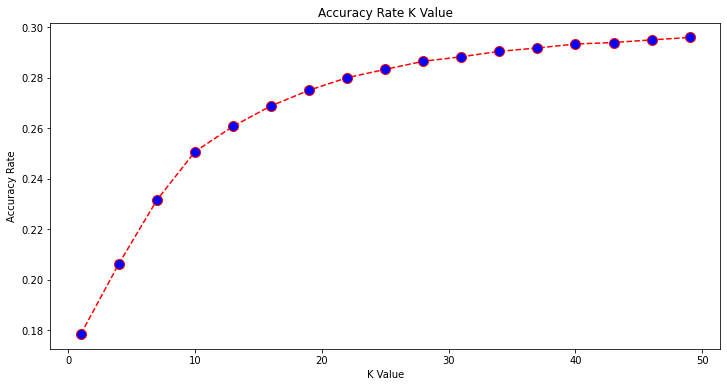

In [0]:
  plt.figure(figsize=(12, 6))
  plt.plot(range(1, 50,3), accuracy_rate, color='red', linestyle='dashed', marker='o',
          markerfacecolor='blue', markersize=10)
  plt.title('Accuracy Rate K Value')
  plt.xlabel('K Value')
  plt.ylabel('Accuracy Rate')

**For k=20 accuracy=28%**

In [0]:
#x[:, 0] = labelencoder.fit_transform(my_dataset_new_drop_arrest[:, 0])
X=my_dataset_new.iloc[:,:3]
y=my_dataset_new.iloc[:,3:]

X_train, X_test, y_train, y_test= train_test_split(X,y,random_state=123, test_size=0.2)
knn= KNeighborsClassifier(n_neighbors=20, p=2, metric='euclidean')
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
print(accuracy_score(y_test,y_pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


0.2833475341672063


**Adding new feature(Location Description) to the exisiting data for better prediction**

In [15]:
le_primarytype = LabelEncoder()
le_arrest = LabelEncoder()
le_locationdescription = LabelEncoder()
dataset_new_pd['new_arrest']=le_arrest.fit_transform(dataset_new_pd['Arrest'])
dataset_new_pd['new_locationdescription']=le_locationdescription.fit_transform(dataset_new_pd['Location Description'])
dataset_new_pd['new_primarytype']=le_primarytype.fit_transform(dataset_new_pd['Primary Type'])
my_dataset_new=dataset_new_pd.drop(['Primary Type','Arrest','Location Description'], axis=1)
my_dataset_new.head()

,Ward,Week,new_arrest,new_locationdescription,new_primarytype
0,41,1,0,3,10
1,42,11,0,142,1
2,4,11,0,125,13
3,49,11,0,122,1
4,4,11,0,142,9


**[Accuracy achieved= 36%]**

In [97]:
#x[:, 0] = labelencoder.fit_transform(my_dataset_new_drop_arrest[:, 0])
X=my_dataset_new.iloc[:,:4]
y=my_dataset_new.iloc[:,4:]

X_train, X_test, y_train, y_test= train_test_split(X,y,random_state=123, test_size=0.2)
knn= KNeighborsClassifier(n_neighbors=20, p=2, metric='euclidean')
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
print(accuracy_score(y_test,y_pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


0.36494658885362274


**Applying Random OverSampling technique**

In [16]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# define oversampling strategy
over = RandomOverSampler(sampling_strategy= 'minority') 

X=my_dataset_new.iloc[:,:4]
y=my_dataset_new.iloc[:,4:]

# fit and apply the transform
X_random, y_random = over.fit_resample(X, y)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


**[Accuracy Achieved=41%]**

In [17]:
X_train, X_test, y_train, y_test= train_test_split(X_random,y_random,random_state=123, test_size=0.2)
knn= KNeighborsClassifier(n_neighbors=20, p=2, metric='manhattan')
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.4106584519307847


**F1 Score**

In [0]:
print('F1 score ', f1_score(y_test, y_pred, average = 'weighted'))


F1 score  0.3164452799354284


**Applying Random UnderSampling technique**

In [21]:
# define oversampling strategy
over = RandomUnderSampler(sampling_strategy= 'majority') 

X=my_dataset_new.iloc[:,:4]
y=my_dataset_new.iloc[:,4:]

# fit and apply the transform
X_random, y_random = over.fit_resample(X, y)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [22]:
X_train, X_test, y_train, y_test= train_test_split(X_random,y_random,random_state=123, test_size=0.2)
knn= KNeighborsClassifier(n_neighbors=20, p=2, metric='manhattan')
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
print(accuracy_score(y_test,y_pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.35839825381758694


**Random UnderSampling technique with sampling_strategy= 'not minority'**

In [110]:
# define undersampling strategy
under = RandomUnderSampler(sampling_strategy= 'not minority') 

X=my_dataset_new.iloc[:,:4]
y=my_dataset_new.iloc[:,4:]

# fit and apply the transform
X_random, y_random = under.fit_resample(X, y)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [111]:
X_train, X_test, y_train, y_test= train_test_split(X_random,y_random,random_state=123, test_size=0.2)
knn= KNeighborsClassifier(n_neighbors=20, p=2, metric='euclidean')
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
print(accuracy_score(y_test,y_pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.26398139001306525


**Random OverSampling technique with sampling_strategy= 'not majority'**

In [112]:
# define oversampling strategy
over = RandomOverSampler(sampling_strategy= 'not majority') 

X=my_dataset_new.iloc[:,:4]
y=my_dataset_new.iloc[:,4:]

# fit and apply the transform
X_random, y_random = over.fit_resample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [113]:
X_train, X_test, y_train, y_test= train_test_split(X_random,y_random,random_state=123, test_size=0.2)
knn= KNeighborsClassifier(n_neighbors=20, p=2, metric='euclidean')
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.35551290653826945
